In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [4]:
import deepmatcher as dm
from utils.intermediate_layer_extraction import return_layer_input
from utils.ri_calculator import computeRi
from utils.distance_measures import nearestNeighborsOnAttribute
import pandas as pd
import torch

In [5]:
attributes = ['Song_Name','Artist_Name','Album_Name','Genre','Price','CopyRight','Time','Released']

## Hybrid

### Datasets creation

In [6]:
hybrid_model = dm.MatchingModel(attr_summarizer='hybrid')
hybrid_model.load_state('../../models/itunes_amazon_hybrid.pth')
hybrid_model = hybrid_model.cuda()

In [13]:
negatives = return_layer_input(hybrid_model,hybrid_model.classifier,'../../Structured/itunes-amazon','negatives')

In [12]:
positives = return_layer_input(hybrid_model,hybrid_model.classifier,'../../Structured/itunes-amazon','positives')

### Negative sample analysis

In [14]:
negatives_ri,neg_rinorms_df= computeRi(hybrid_model.classifier,
                                                    attributes,negatives,1)

100%|██████████| 407/407 [00:56<00:00,  7.20it/s]


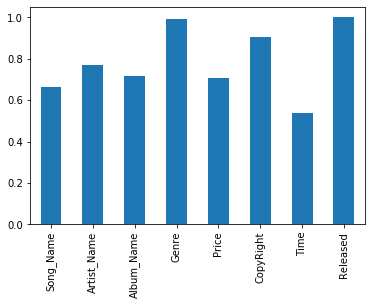

In [20]:
rankings = neg_rinorms_df.sum()
maxrank = max(rankings)
(rankings/maxrank).plot.bar()

In [21]:
torch.save(negatives_ri,'experiments/results/neg_ri_hybrid.pt')

## Positive samples analisys

In [18]:
pos_ri_hybrid,pos_rinorms_df = computeRi(hybrid_model.classifier,attributes,
                                              positives,0)

100%|██████████| 132/132 [00:29<00:00,  4.52it/s]


In [22]:
pos_rankings = pos_rinorms_df.sum()
maxrank_pos = max(pos_rankings)
(pos_rankings/maxrank_pos)

Song_Name      0.559880
Artist_Name    0.667201
Album_Name     0.608784
Genre          0.929250
Price          0.589067
CopyRight      0.911290
Time           0.429835
Released       1.000000
dtype: float64

In [20]:
torch.save(pos_ri_hybrid,'experiments/results/pos_ri_hybrid.csv')

## Nearest neighbors hybrid

In [22]:
positives_nn_hybrid = calculate_nearest_neighbors_onAttributes(positives,pos_ri_hybrid,
                                                       negatives,attributes,attribute_len_hybrid,
                                                               min_similarity=0)

100%|██████████| 132/132 [00:00<00:00, 213.55it/s]


In [23]:
negatives_nn_hybrid = calculate_nearest_neighbors_onAttributes(negatives,negatives_ri,
                                                        positives,attributes,attribute_len_hybrid,
                                                               min_similarity=0)

100%|██████████| 407/407 [00:01<00:00, 265.70it/s]


In [24]:
positives_nn_hybrid.to_csv('experiments/results/positivesNNHybridWithoutfilter.csv',index=False)
negatives_nn_hybrid.to_csv('experiments/results/negativesNNhybridWithoutfilter.csv',index=False)

In [28]:
positives_nn_hybrid['Price'].value_counts()

99    132
Name: Price, dtype: int64

In [30]:
negatives = pd.read_csv('../../Structured/itunes-amazon/negatives.csv')
positives = pd.read_csv('../../Structured/itunes-amazon/positives.csv')